In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
style.use('seaborn-pastel')

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
!ls data

X_test.csv
X_train.csv
sample_submission.csv
y_train.csv


# Load Data

In [4]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')
X_test = pd.read_csv('data/X_test.csv')

# EDA

## Data quality and key characteristics

In [5]:
print(X_train.shape, X_test.shape)
X_train.head()

(487680, 13) (488448, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
print(y_train.shape)
y_train.head()

(3810, 3)


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [7]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0)

There is no missing data in the training or test set.

In [8]:
np.all(X_train['series_id'].unique() == y_train['series_id'].unique())

True

In [9]:
np.all(X_train['series_id'].value_counts().values == 128)

True

In [10]:
X_test['series_id'].nunique(), np.all(X_test['series_id'].value_counts().values == 128)

(3816, True)

The training data contains 3810 series, each comprised of 128 measurements. The test data contains 3816 series, each comprised of 128 measurements.

Number of group_id in training data:  73
Each group_id corresponds to a single surface:  True


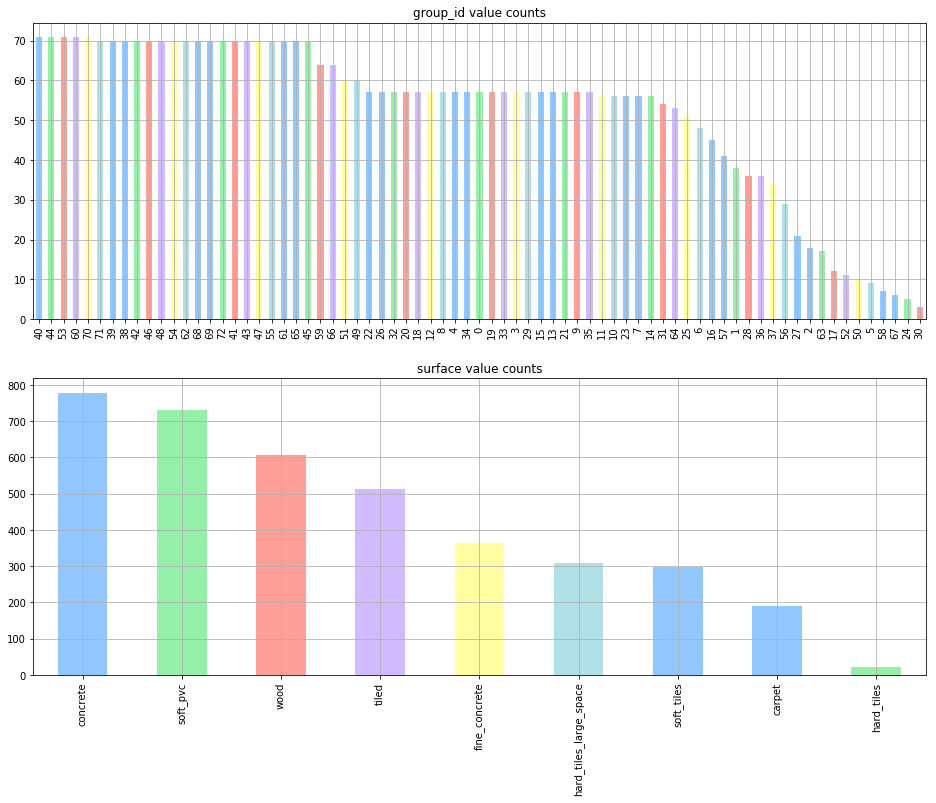

In [11]:
print("Number of group_id in training data: ", y_train['group_id'].nunique())
print("Each group_id corresponds to a single surface: ", np.all(y_train.groupby('group_id')['surface'].nunique() == 1))
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
y_train['group_id'].value_counts().plot.bar(title='group_id value counts', ax=axes[0])
y_train['surface'].value_counts().plot.bar(title='surface value counts', ax=axes[1])
axes[0].grid(True)
axes[1].grid(True);

Each of the 73 groups corresponds to a single surface type. The groups and classes (surfaces) are both heavily imbalanced.

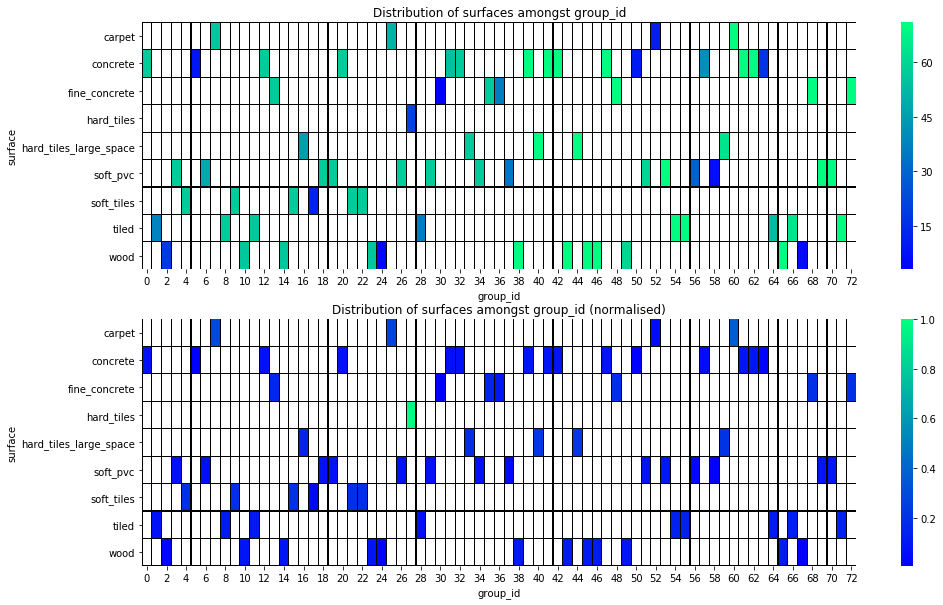

In [12]:
series_counts = y_train.groupby(['group_id', 'surface'])['series_id'].count().reset_index()
series_counts_matrix = series_counts.pivot(index='surface', columns='group_id', values='series_id')
series_counts_matrix_norm = (series_counts_matrix.T / series_counts_matrix.sum(axis=1).values).T
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0] = sns.heatmap(series_counts_matrix, ax=axes[0], linewidths=.1, linecolor='k', cmap='winter')
axes[1] = sns.heatmap(series_counts_matrix_norm, ax=axes[1], linewidths=.1, linecolor='k', cmap='winter')
axes[0].set_title('Distribution of surfaces amongst group_id')
axes[1].set_title('Distribution of surfaces amongst group_id (normalised)');

## Connecting the time series

Adapted from <a href="https://www.kaggle.com/friedchips/the-missing-link">Markus F's kernel</a>.

By observing the orientations of series from the same group_id, it can be seen that they correspond to measurments from a single continuous run.

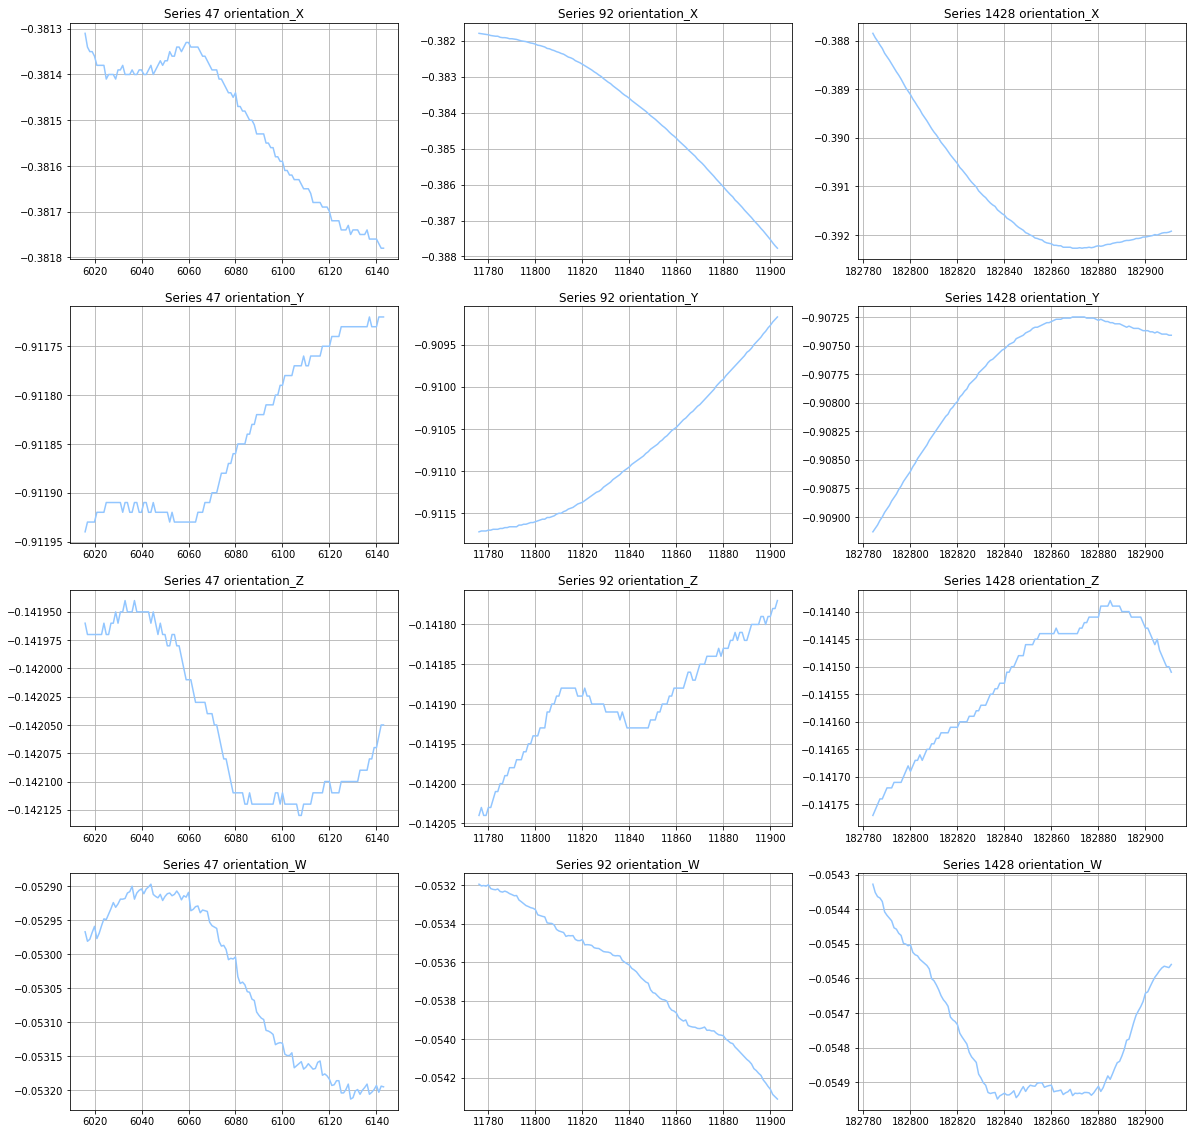

In [13]:
# For example, group_id 30 (fine_concrete)
group_id_30_series = y_train.loc[y_train['group_id'] == 30, 'series_id'].values

fig, axes = plt.subplots(4, 3, figsize=(20, 20))
for i, series in enumerate(group_id_30_series):
    data = X_train.loc[X_train['series_id'] == series,
                       ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W']]
    for j, col in enumerate(data.columns):
        data[col].plot(ax=axes[j][i], title="Series {} {}".format(series, col))
        axes[j][i].grid(True)

Thus it is possible to connect time series into continuous runs. Connected series can be found by computing the euclidean distances between two series and pairing series that mutually share a minimum distance between each other. If the minimum euclidean distance isn't mutual between two series (it's only a minimum for one of the two series), we can infer that the series whose partner does not reciprocate a minimum distance is probably an edge (the first or last series) in a continuous run.

We start by reshaping the data into convenient dimensions for further manipulation.

In [14]:
# n series of 128 measurements
# 10 variables - 4x orientation, 3x angular velocity, 3x linear velocity
data_train = X_train.values[:, 3:].reshape(-1, 128, 10)
data_test = X_test.values[:, 3:].reshape(-1, 128, 10)
print(data_train.shape, data_test.shape)

(3810, 128, 10) (3816, 128, 10)


Then we identify the edge series, as explained above.

In [20]:
def squared_distances(a, b):
    return np.sum((a-b)**2, axis=1)


def find_edge_series(data, edge):
    # edge is either 'left' or 'right'
    
    if edge == 'left':
        a, b = 0, -1
    elif edge == 'right':
        a, b = -1, 0
    else:
        return False
    
    edges = []
    links = []
    
    for series in range(len(data)):
        distances = squared_distances(data[series, a, :4], data[:, b, :4])
        min_dist = np.min(distances)
        series_closest = np.argmin(distances)
        if series == series_closest:
            series_closest = np.argsort(distances)[1] # Series cannot pair with itself
        
        # check if the closest series reciprocates the minimum distance
        distances = squared_distances(data[series_closest, b, :4], data[:, a, :4])
        min_dist_closest = np.min(distances)
        series_reverse = np.argmin(distances)
        if series_closest == series_reverse:
            series_reverse = np.argsort(distances)[1]
            
        if series != series_reverse: # edge found
            edges.append(series)
        else:
            links.append([series, series_closest, min_dist])
            
    return edges, links

In [21]:
%%time
starts_train, left_links_train = find_edge_series(data_train, 'left')
ends_train, right_links_train = find_edge_series(data_train, 'right')
print(len(starts_train), len(ends_train))

76 76
Wall time: 31.6 s


Equal numbers of start series and end series have been found.

We can now piece together the continuous runs by starting with the start edges and joining series together until we encounter an end series.

In [22]:
def find_continuous_runs(data, starts, ends):
    runs = []

    for start in starts:
        series = start
        run = [series]
        while series not in ends:
            closest_series = np.argmin(squared_distances(data[series, -1, :4], data[:, 0, :4]))
            if series == closest_series:
                closest_series = np.argsort(squared_distances(data[series, -1, :4], data[:, 0, :4]))[1]
            series = closest_series
            run.append(series)
        runs.append(np.array(run))
    
    return runs

In [23]:
%%time
runs_train = find_continuous_runs(data_train, starts_train, ends_train)
runs_train_flat = [series for run in runs_train for series in run]
print("Number of series in training data: ", len(data_train))
print("Number of series in runs_train: ", len(runs_train_flat))
print("Unique series in runs_train: ", len(runs_train_flat))

Number of series in training data:  3810
Number of series in runs_train:  3810
Unique series in runs_train:  3810
Wall time: 7.85 s


We can check the continuous runs found to see how many surfaces they correspond to.

In [24]:
for i, run in enumerate(runs_train):
    n_surfaces = len(y_train.loc[y_train['series_id'].isin(run), 'surface'].unique())
    if n_surfaces != 1:
        print("Run {} contains {} surfaces".format(i, n_surfaces))

Run 7 contains 2 surfaces
Run 52 contains 2 surfaces
Run 59 contains 2 surfaces
Run 71 contains 2 surfaces


Four runs contain two surfaces - all the other have just one. By plotting these four runs, we can visually see the point where the surface changes.

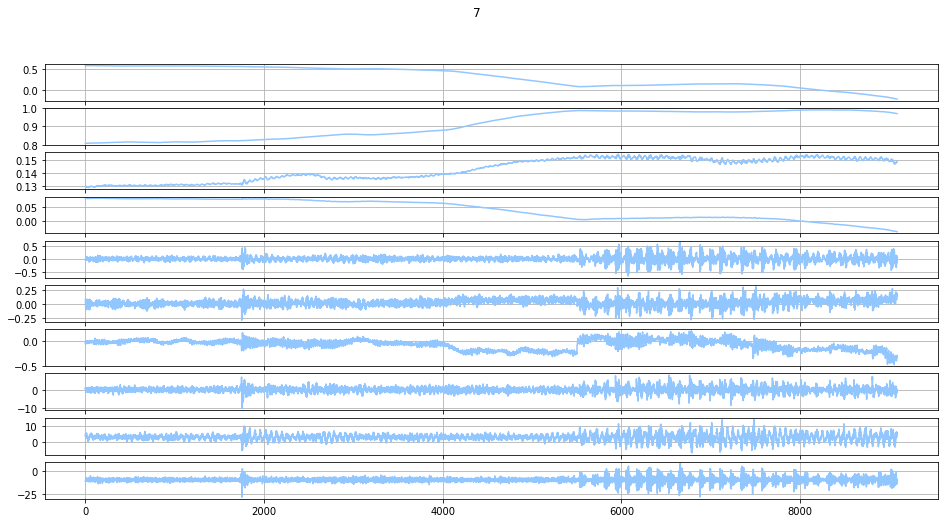

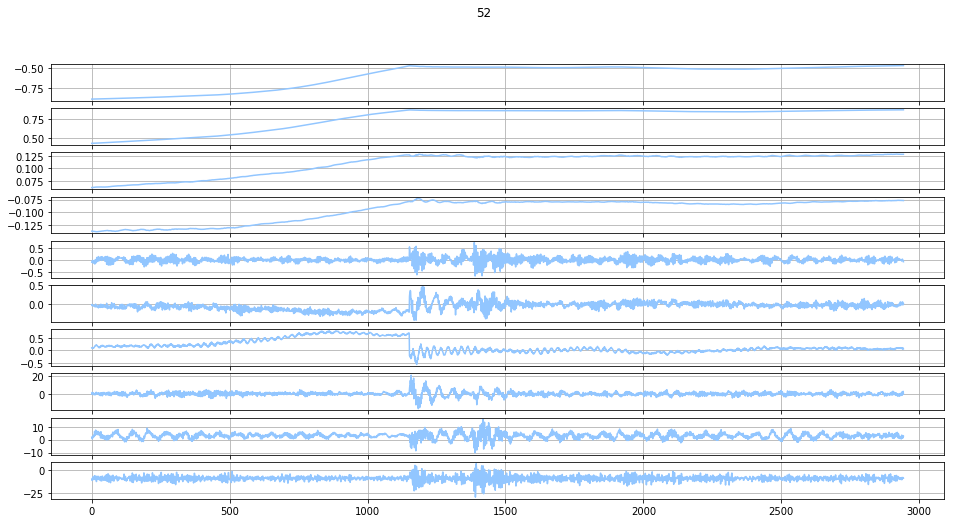

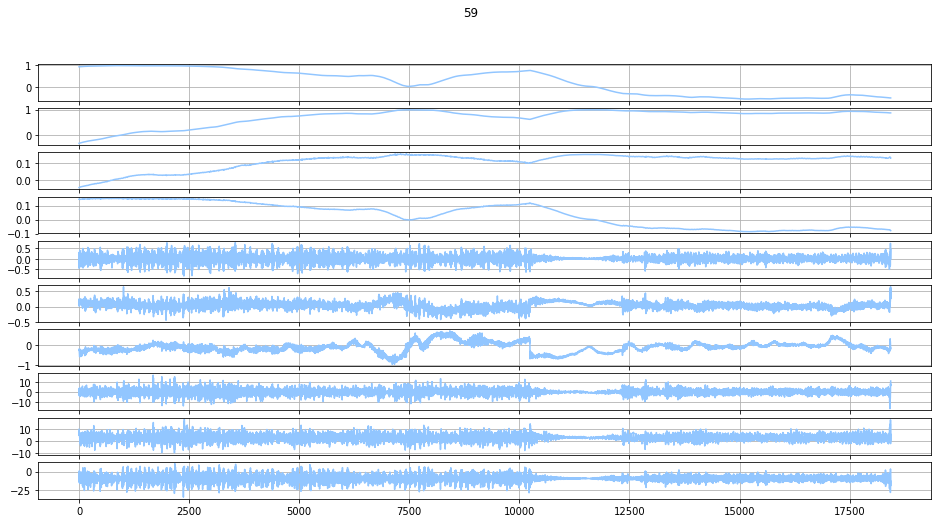

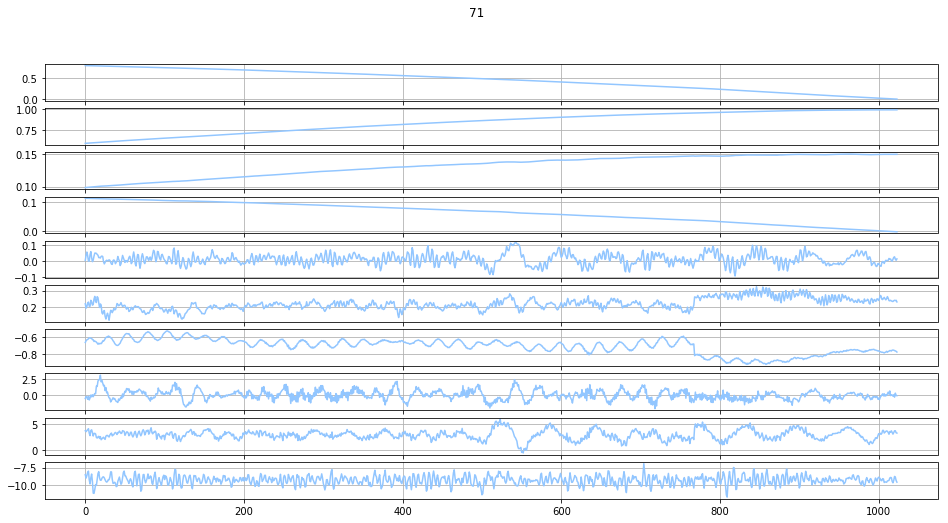

In [25]:
for run in [7, 52, 59, 71]:
    fig, axes = plt.subplots(10,1, sharex=True, figsize=(16, 8))
    for i in range(10):
        axes[i].plot(data_train[runs_train[run]][:,:,i].reshape(-1))
        axes[i].grid(True)
    fig.suptitle(run)

We can capture this run information in y_train and then subsequently adjust for the four cases where two surfaces were found for a single run.

In [26]:
n_runs = len(runs_train)

y_train['run'] = np.nan
for i, run in enumerate(runs_train):
    y_train.loc[y_train['series_id'].isin(run), 'run'] = int(i)
    
for run in y_train['run'].unique():
    surfaces = y_train.loc[y_train['run'] == run, 'surface'].unique()
    if len(surfaces) > 1:
        for surface in surfaces[1:]:
            n_runs += 1
            y_train.loc[(y_train['run'] == run) & (y_train['surface'] == surface), 'run'] = n_runs

### Repeating for the test data

We can run the same analysis using the test data.

In [27]:
%%time
starts_test, left_links_test = find_edge_series(data_test, 'left')
ends_test, right_links_test = find_edge_series(data_test, 'right')
print(len(starts_test), len(ends_test))

75 75
Wall time: 29.9 s


In [28]:
%%time
runs_test = find_continuous_runs(data_test, starts_test, ends_test)
runs_test_flat = [series for run in runs_test for series in run]
print("Number of series in test data: ", len(data_test))
print("Number of series in runs_test: ", len(runs_test_flat))
print("Unique series in runs_test: ", len(runs_test_flat))

Number of series in test data:  3816
Number of series in runs_test:  3790
Unique series in runs_test:  3790
Wall time: 7.87 s


We've missed 26 series from the test data, which do not have a start/end edge. These must correspond to a loop.

In [29]:
missing_test = np.array([i for i in range(len(data_test)) if i not in np.concatenate(runs_test)])
print(len(missing_test))

26


In [30]:
missing_start, missing_left_links = find_edge_series(data_test[missing_test], 'left')
missing_end, missing_right_links = find_edge_series(data_test[missing_test], 'right')

In [31]:
print(missing_start, missing_end)
print(len(missing_left_links), len(missing_right_links))

[] []
26 26


No start or end, therefore it's a loop. We can manually choose a start and end point for the loop to find the complete missing run.

In [32]:
missing_left_links[0]

[0, 5, 2.0548399999999954e-07]

In [33]:
missing_run = missing_test[find_continuous_runs(data_test[missing_test], [0], [5])]
print(len(missing_run))
runs_test.append(missing_run)
runs_test_flat = [series for run in runs_test for series in run]
print(len(runs_test_flat))

26
3816


By visually inspecting all the continuous runs, we identify run that should be split (runs we suspect correspond to more than one surface). This manual exercise is omitted, but the splits are shown below.

In [34]:
runs_test_orig = runs_test[:]

runs_test.append(runs_test[0][101:])
runs_test[0] = runs_test[0][:101]

runs_test.append(runs_test[5][-5:])
runs_test[5] = runs_test[5][:-5]

runs_test.append(runs_test[52][55:])
runs_test[52] = runs_test[52][:55]

We can capture this run information in y_train and then subsequently adjust for the four cases where two surfaces were found for a single run.

In [35]:
y_predictions = pd.DataFrame(columns=['series_id', 'surface', 'run'])
y_predictions['series_id'] = X_test['series_id'].unique()
for i, run in enumerate(runs_test):
    y_predictions.loc[y_predictions['series_id'].isin(run), 'run'] = i
y_predictions.head()

,series_id,surface,run
0,0,NaN,14
1,1,NaN,57
2,2,NaN,42
3,3,NaN,65
4,4,NaN,68


Now when we generate predictions, we can ensure that series for each run correspond to a unique surface (and use the consensus to make corrections).

## Analysis of time series

Create a convenience function for easy visualisation of the time series.

In [36]:
series_dict = {}
for series in X_train['series_id'].unique():
    series_dict[series] = X_train.loc[X_train['series_id'] == series]
    
def plot_series(series_id):
    plt.subplots(figsize=(24,18))
    for i, col in enumerate(series_dict[series_id].columns[3:]):
        colour = 'red'
        if i > 3: colour = 'blue'
        if i > 6: colour, i = 'green', i+1
        plt.subplot(3, 4, i+1)
        plt.plot(series_dict[series_id][col], color=colour)
        plt.grid(True)
    print("Series:\t\t", series_id)
    print("Surface:\t", y_train.loc[y_train['series_id'] == series_id, 'surface'].values[0])

Series:		 0
Surface:	 fine_concrete


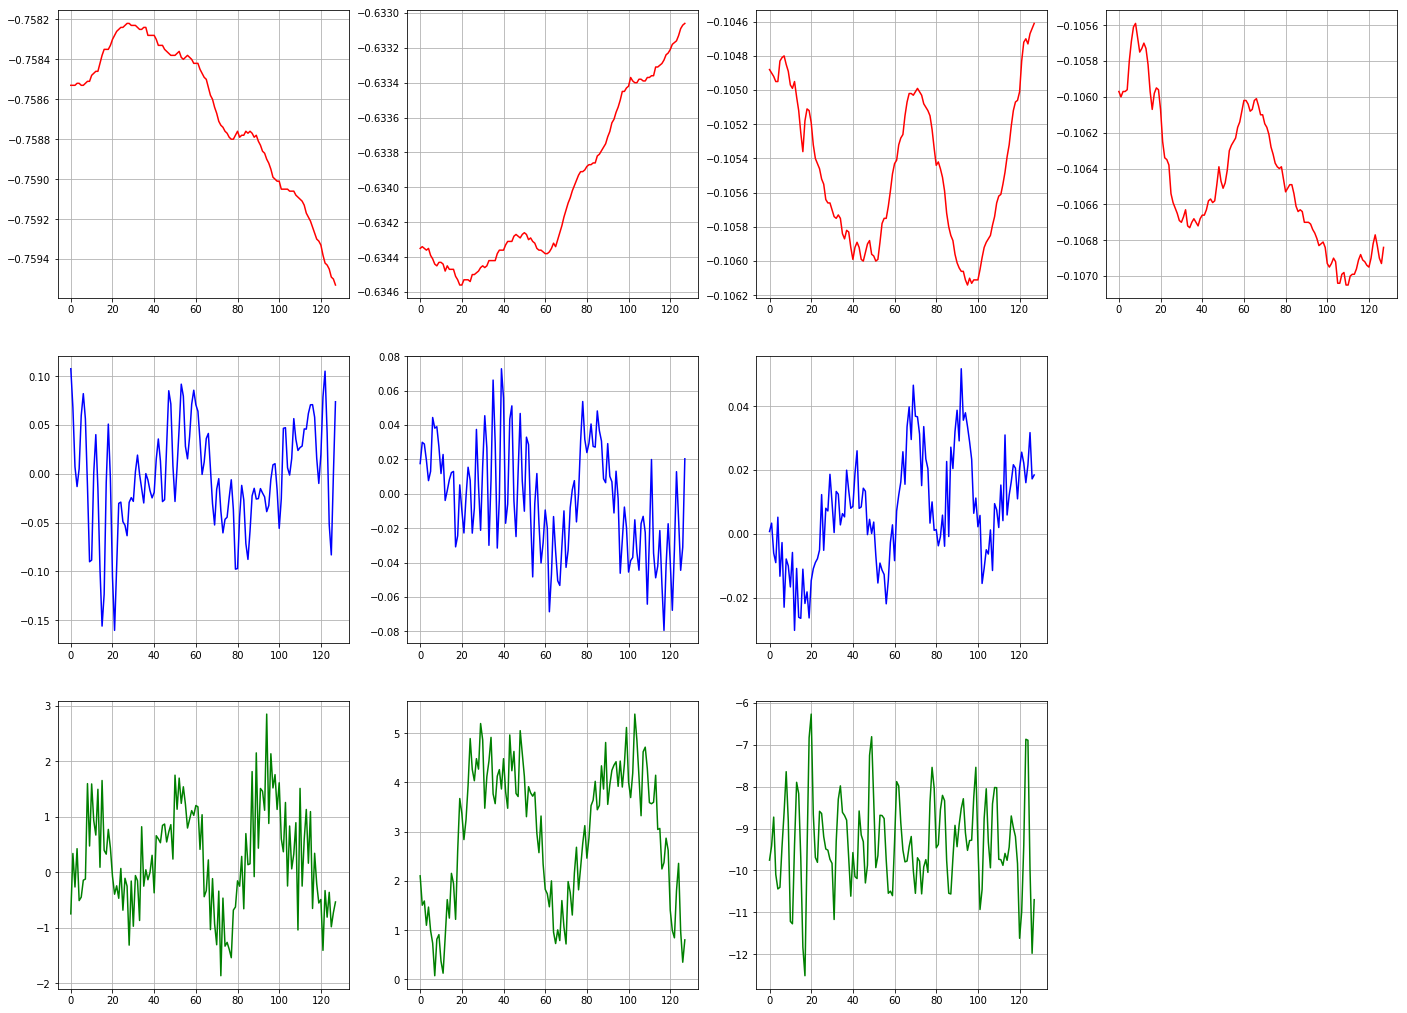

In [37]:
plot_series(0)